In [1]:
import os
import time
import tensorflow as tf
# modified to solve placeholder() error
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import numpy as np
from glob import glob
import datetime
import random
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from  tensorflow import keras
from  tensorflow.keras import layers

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [4]:
image_size = (180, 180)
batch_size = 32

train_ds = keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/ANN/petsmallest",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/MyDrive/ANN/petsmallest",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2257 files belonging to 2 classes.
Using 1806 files for training.
Found 2257 files belonging to 2 classes.
Using 451 files for validation.


In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [6]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [8]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

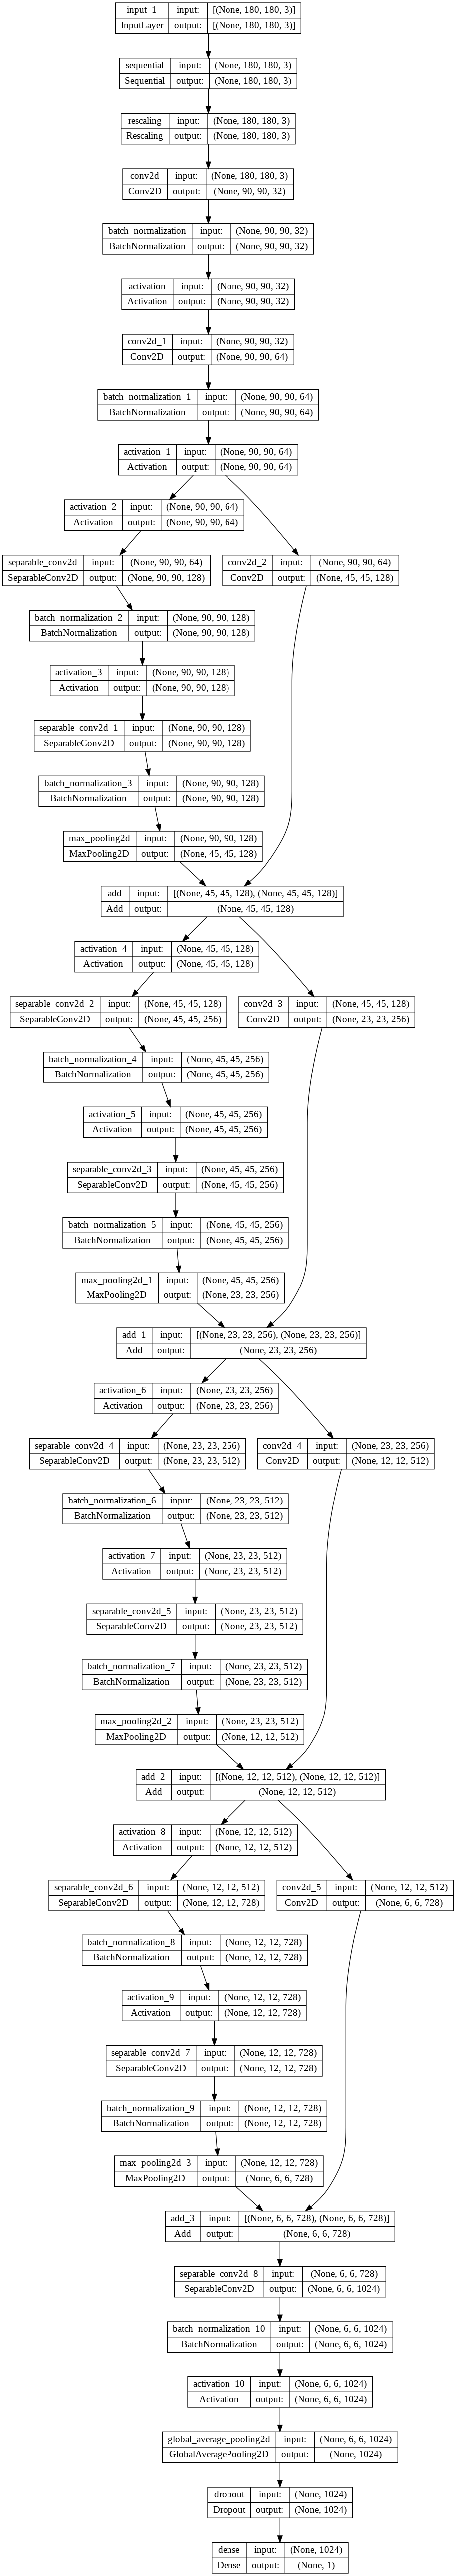

In [9]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [10]:
'''
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
   metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)
'''

'\nepochs = 5\n\ncallbacks = [\n    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),\n]\nmodel.compile(\n    optimizer=keras.optimizers.Adam(1e-3),\n    loss="binary_crossentropy",\n   metrics=["accuracy"],\n)\nmodel.fit(\n    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,\n)\n'

In [11]:
epochs = 45

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, validation_data=val_ds,
)

Epoch 1/45
57/57 [==============================] - 122s 2s/step - loss: 0.7716 - accuracy: 0.5681 - val_loss: 0.6935 - val_accuracy: 0.4856
Epoch 2/45
57/57 [==============================] - 16s 269ms/step - loss: 0.6807 - accuracy: 0.6141 - val_loss: 0.7091 - val_accuracy: 0.4856
Epoch 3/45
57/57 [==============================] - 16s 273ms/step - loss: 0.6331 - accuracy: 0.6495 - val_loss: 0.7501 - val_accuracy: 0.4856
Epoch 4/45
57/57 [==============================] - 16s 272ms/step - loss: 0.5924 - accuracy: 0.6982 - val_loss: 0.8862 - val_accuracy: 0.4856
Epoch 5/45
57/57 [==============================] - 16s 271ms/step - loss: 0.5580 - accuracy: 0.7243 - val_loss: 1.0333 - val_accuracy: 0.4856
Epoch 6/45
57/57 [==============================] - 16s 269ms/step - loss: 0.5690 - accuracy: 0.7281 - val_loss: 0.9293 - val_accuracy: 0.4856
Epoch 7/45
57/57 [==============================] - 16s 269ms/step - loss: 0.5254 - accuracy: 0.7458 - val_loss: 0.9552 - val_accuracy: 0.4856
E

In [12]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/ANN/petsmallest/Cat/0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 1s 635ms/step
This image is 67.72 percent cat and 32.28 percent dog.


In [13]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/ANN/petsmallest/Dog/4.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 16ms/step
This image is 0.00 percent cat and 100.00 percent dog.


In [14]:
img = keras.preprocessing.image.load_img(
    "/content/gdrive/MyDrive/ANN/petsmallest/Dog/31.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 15ms/step
This image is 0.03 percent cat and 99.97 percent dog.
